# Tutorial for NIRCam Coronagraphy Reduction with spaceKLIP
---

In this notebook, you will learn how to reduce NIRCam coronagraphy data from the JWST ERS program on Direct Observations of Exoplanetary Systems ([Program 1386](https://www.stsci.edu/jwst/science-execution/program-information?id=1386)), with a focus on the exoplanet HIP 65426 b. The tutorial guides you step-by-step through the data reduction process using the spaceKLIP pipeline, offering a clear and concise workflow tailored for effective high-contrast imaging analysis. By the end of this notebook, you will have gained hands-on experience with the tools and techniques necessary for reducing NIRCam coronagraphic data, preparing you to apply these methods to other similar datasets.

<div class="alert alert-warning">
<b>Relation to other tutorials:</b> This notebook is intentionally very similar to the MIRI data reduction notebook.  Subsequent analyses will be done in the "Tutorial for NIRCam Post-Pipeline Contrast Analyses Using spaceKLIP" notebook. 
</div>

<div class="alert alert-info">
<b>NIRCam-specific information:</b> Steps and information specific to NIRCam are called out in blue.</div>


<h1 style="font-size: 24px; font-weight: 550;">Table of Contents</h1>

* [1. Introduction](#Introduction)
* [2. Setup and Imports](#Setup-and-Imports)
* [3. Download the Data](#Precursor:-Download-the-Data)
* [4. Stage 1 Reductions](#Stage-1-Reductions)
    * [4.1 Index Files into Database for Stage 1](#Index-Files-into-Database-for-Stage-1)
    * [4.2 Run Stage 1 Pipeline](#Run-Stage-1-Pipeline)
    * [4.3 Display Stage 1 Reductions](#Display-Stage-1-Reductions)
* [5. Stage 2 Reductions](#Stage-2-Reductions)
    * [5.1 Re-read Stage 1 Outputs into Database](#Optional:-Re-read-Stage-1-Outputs-into-Database)
    * [5.2 Run Stage 2 Pipeline](#Run-Stage-2-Pipeline)
    * [5.3 Display Stage 2 Reductions](#Display-Stage-2-Reductions)
* [6. Stage 3 reductions: Preparations for PSF subtraction](#Stage-3-Reductions:-Preparations-for-PSF-Subtraction
)
    * [6.1 Re-read Stage 2 Outputs into Database](#Optional:-Re-read-Stage-2-Outputs-into-Database)
    * [6.2 Using spaceKLIP ImageTools](#Using-spaceKLIP-ImageTools)
    * [6.3 Median-subtract Each Frame](#Median-subtract-Each-Frame)
    * [6.4 Find and Repair Bad Pixels](#Find-and-Repair-Bad-Pixels)
    * [6.5 Finish Pixel Cleanup](#Finish-Pixel-Cleanup)
    * [6.6 Improve PSF Centering and Alignment](#Improve-PSF-Centering-and-Alignment)
        * [6.6.1 Update NIRCam PSF Center Metadata](#Update-NIRCam-PSF-Center-Metadata)
        * [6.6.2 Re-center the Frames](#Re-center-the-Frames)
        * [6.6.2 Align Frames](#Align-Frames)
    * [6.7 Pad Empty Space Around Frames](#Pad-Empty-Space-Around-Frames)
    * [6.8 Display the Cleaned Datasets](#Display-the-Cleaned-Datasets)
* [7. Stage 3 Reductions: KLIP](#Stage-3-Reductions:-KLIP)
    * [7.1 PSF Subtraction: Option Using pyKLIP](#PSF-Subtraction:-Option-Using-pyKLIP)
    * [7.2 Re-read Stage 3 Outputs into Database](#Optional:-Re-read-Stage-3-Outputs-into-Database)

---

## Introduction

Directly imaging a planet or circumstellar disk around another star is a challenging task that requires specialized techniques and systems to suppress the star's bright light while preserving the faint light from the planet or disk, which otherwise would be obscured by the star's glare. This is achieved using starlight suppression optical systems, such as a starshade occulter or coronagraph, active wavefront control, advanced image processing techniques like differential imaging, and post-processing algorithms that effectively remove residual starlight (also referred to as speckles) using point spread function (PSF) subtraction methods. These advanced astronomical technologies and techniques enable High-Contrast Imaging (HCI), making it possible to study and characterize planetary systems in unprecedented detail.

A coronagraph instrument is a fundamental technology used for HCI as it is designed to block the light of an on-axis source, such as a star's light, using an internal or external occulter while letting the light of off-axis sources, like planets, to continue to pass through the optical system to the detector. The most common type of coronagraph is a Lyot-coronagraph which the Near Infrared Camera (NIRCam) on the James Webb Space Telescope (JWST) exemplifies, featuring five [Lyot-type coronagraphs](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-high-contrast-imaging/jwst-high-contrast-imaging-supporting-technical-information/hci-optics#HCIOptics-LyCLyot-typecoronagraph:~:text=in%20the%20documentation.-,Lyot%2Dtype%20coronagraph,-See%20also%3A%C2%A0) that facilitate HCI at wavelengths of 2–5 µm with sub-arcsecond [inner working angles (IWA)](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-high-contrast-imaging/jwst-high-contrast-imaging-supporting-technical-information/hci-inner-working-angle#gsc.tab=0:~:text=Inner%20Working%20Angle-,HCI%20Inner%20Working%20Angle,-The%20JWST%20inner) that allow for imaging of objects very close to their host. However, coronagraphs have certain limitations.

While coronagraphs block most of the star's light, there is some star leakage (or diffracted starlight) that propagates to the detector and results in a residual starlight "speckle" pattern or static wavefront errors that require additional post-processing and imaging techniques to remove. Also, the coronagraph design places constraints on the field of view (i.e., IWA), bandpass limitations, etc.

To address the limitations of coronagraphy, differential imaging techniques are used to separate starlight from the faint signals of celestial companions by exploiting differences in target, wavelength, or angular position. We use the following later in the notebook:

* **Angular Differential Imaging (ADI)**: This technique relies on the rotation of the telescope to capture a series of images at different field orientations. By aligning and combining these images, ADI can effectively differentiate the relatively static starlight from the rotating signal of the faint companion, enhancing contrast and detectability.
* **Reference Differential Imaging (RDI)**: This technique uses reference images of similar stars taken under similar observing conditions to subtract starlight from the target star's images. 
* **Spectral Differential Imaging (SDI)**: This technique takes advantage of the wavelength-dependent differences in the light from a star and its companion. Comparing images taken at different wavelengths helps suppress starlight while preserving the signal from the companion.

Post-processing algorithms such as Karhunen-Loève Image Processing (KLIP) are used to perform PSF Subtraction and can enhance differential imaging techniques like ADI, RDI, and SDI. KLIP uses Principal Component Analysis (PCA) to create a model of the residual starlight PSF tailored to the observed data. Subtracting this model from the images helps remove the leftover residual light while preserving the light from faint sources. The [spaceKLIP data reduction pipeline](https://spaceklip.readthedocs.io/en/latest/) simplifies and streamlines the reduction and application of KLIP on JWST high-contrast imaging data.

**ADDITIONAL RESOURCES**

* [HCI Overview](https://iopscience.iop.org/article/10.1088/1538-3873/aceb31#:~:text=HCI%20is%20a%20catchall%20term,the%20vicinity%20of%20bright%20stars.): A comprehensive introduction to High-Contrast Imaging.
* [PCA Example](https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184): A clear example to visualize Principal Component Analysis.


---


## Setup and Imports

In [14]:
%load_ext autoreload
%autoreload 2
    
import os
import numpy as np
import subprocess

import spaceKLIP

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We're not interested in that logging text, so let's quiet it. 



In [2]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

---

## Precursor: Download the Data

If you already have a copy of this data, you can adjust the paths below accordingly. In this notebook, we assume you don't have the data yet, so let's download it here.

We will use the [`jwst_mast_query`](https://github.com/spacetelescope/jwst_mast_query) package for this. Consult the package's documentation for more details.

We'll download all the uncalibrated raw data (`uncal.fits`), as we will use spaceKLIP to invoke the [JWST pipeline](https://github.com/spacetelescope/jwst) with customized options and extra steps optimized for coronagraphy.

In [3]:
# Name the root directory where we will keep the data for this tutorial.
data_root = 'data_nircam_hd65426'

In [4]:
# Make subdirectories to put the data in.

os.makedirs(data_root, exist_ok=True)
os.makedirs(os.path.join(data_root, 'uncal'), exist_ok=True)

# Invoke the download.
download_cmd = (
    "yes | jwst_download.py --propID 1386 -i nircam -l 700 --obsnums 1 2 3 "
    "--outsubdir data_nircam_hd65426/uncal --skip_propID2outsubdir "
    "-f uncal --date_select 59789.0+"
)

subprocess.Popen(download_cmd, shell=True).wait()

INSTRUMENT:  nircam
obsmode:  [None]
propID:  01386
obsnums:  [1, 2, 3]
INFO: MAST API token accepted, welcome Kayli Glidic [astroquery.mast.auth]
MJD range: 59789.0 60571.73122349747
No obsmode given. Querying for all files for nircam.
allowed filetype list: ['_uncal.fits']
select obsnum [1, 2, 3]: keeping 64 from 101

######################
### Selected Products:
######################
 proposal_id obsnum    obsID  parent_obsid                             obs_id   sca visit dataproduct_type                               productFilename    filetype  calib_level     size                                   description
        1386      1 87767907      91707772 jw01386001001_03106_00008_nrcalong along   001            image jw01386001001_03106_00008_nrcalong_uncal.fits _uncal.fits            1  4155840 exposure (L1b): Uncalibrated 4D exposure data
        1386      1 87767908      91707772 jw01386001001_03106_00009_nrcalong along   001            image jw01386001001_03106_00009_nrcalong_u

0

---

## Stage 1 Reductions

### Index Files into Database for Stage 1
SpaceKLIP relies on a `Database` class to track observations, data files, and the relationships between them. 

We begin by creating a database and reading files into it. 

For this tutorial, let's only reduce one filter's worth of data. 

In [4]:
filt = 'F444W'  # Set to None to disable filter selection and load all filters.

In [6]:
# Initialize spaceKLIP database.

database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'uncal'),
                                    output_dir=data_root,
                                    filt=filt,
                                    pid=1386)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... PIXAR_SR BUNIT      ROLL_REF      BLURFWHM
---- --------- -------- -------- ... -------- ----- ------------------ --------
 SCI NRC_CORON   STAGE0     JWST ...      nan    DN 110.30193021092403      nan
 SCI NRC_CORON   STAGE0     JWST ...      nan    DN 120.38229928192678      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN 110.03164126509459      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN 110.03167095674748      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN 110.03169329690344      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN 110.03168369757408      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN 110.03167513958529      nan
 REF NRC_CORON   STAGE0     JWST ...      nan    DN 110.03166494524143      nan
 REF NRC_CORON   STAGE0     JWST ..

The above is a bit verbose and can be difficult for a human to parse; let's ask the database to summarize what it contains: 

In [7]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE0: 11 files;	2 SCI, 9 REF


Above, you should notice two types of files contained in the database:
* **`SCI` (Science)**: These files hold the primary coronagraphic observational data of the target—in this case, the exoplanet host star HIP 65426. This program also conducted coronagraphic observations at two separate roll angles, which refer to specific pointing/orientation of the telescope. Hence, there are two `SCI` files.
* **`REF` (Reference)**: These files contain the reference PSF observations of other stars—in this case, of the nearby star HIP 65219.

---

### Run Stage 1 Pipeline


The `Coron1Pipeline` ([calwebb_coron1](https://spaceklip.readthedocs.io/en/latest/stage1.html)) in spaceKLIP is a custom subclass of the JWST Stage 1 pipeline, `Detector1Pipeline` ([calwebb_detector1](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1)). It is specifically designed to optimize the processing of high-contrast imaging data typical of coronagraphic observations. This pipeline applies group-by-group detector-level corrections, followed by ramp fitting, to the raw, uncalibrated data ([`uncal.fits`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#:~:text=g.%20%E2%80%9Cjw80600012001_02101_00003_mirimage_ramp.fits%E2%80%9D.-,Inputs,-%EF%83%81)). The output is calibrated count rate products ([`rateints.fits`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#:~:text=be%20ImageModel.-,3D%20countrate%20product,%EF%83%81,-Data%20model)).

The `Coron1Pipeline` performs the following steps for NIRCam. Custom spaceKLIP steps and parameters are bolded. Hover and click on links to learn more about specific JWST pipeline steps.

> * [`group_scale`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/group_scale/description.html)
> * [`dq_init`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/dq_init/description.html)
> * [`saturation`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/description.html):
>   * **`flag_rcsat`**: Flag high dark current RC pixels as saturated? (Default: False).
>   * **`grow_diagonal`**: Flag diagonal neighboring pixels (or only bottom/top/left/right)? (Default: True).
>   * [`n_pix_grow_sat`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/arguments.html)
> * [`ipc`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ipc/description.html)
> * [`superbias`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/superbias/description.html)
> * [`refpix`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/index.html)
>    * [`odd_even_columns`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/arguments.html#:~:text=%2D%2D-,odd_even_columns,-If%20the%20odd_even_columns)
>    * **`nlower`**, **`nupper`**, **`nleft`**, **`nright`**</span>: Number of pixels around edges to use as pseudo-refpix in NIRCam subarrays (Default: 4).
>    * **`nrow_off`**, **`ncol_off`**: Offset the reference pixel region from the top/bottom and left/right edges of the frame (Default: 0).
> * [`linearity`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/description.html) 
> *  [`dark_current`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/dark_current/description.html) 
> * [`persistence`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/persistence/description.html)
> * [`jump detection`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/description.html)
>   * [`rejection_threshold`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=%2D%2D-,rejection_threshold,-%3A%20A%20floating%2Dpoint), [`three_group_rejection_threshold`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=three_group_rejection_threshold), [`four_group_rejection_threshold`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=four_group_rejection_threshold), [`maximum_cores`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html#:~:text=%2D%2D-,maximum_cores,-%3A%20The%20number%20of)
> * **`subtract_1overf`**: Removes 1/f noise from the data.
>    * **`model_type`**: Type of model to fit for 1/f noise removal ('median', 'mean', Defualt: 'savgol')
>    * **`sat_frac`**: Maximum saturation fraction for fitting slopes (Default: 0.5)
>    * **`combine_ints`**: Combine all integrations before ramp fitting? (Default: True)
>    * **`vertical_corr`**: Apply a vertical correction to remove vertical striping (Default: True)
>    * **`nproc`**: Number of processes to use for parallel processing (Default: 4)
> * [`ramp_fit`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/description.html)
>      * **`save_calibrated_ramp`**: Save the calibrated ramp? The default is False.
> * [`gain_scale`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/gain_scale/description.html). 


The following cell will run the `Coron1Pipeline` for all input data in the spaceKLIP database, saving the output to a subdirectory named `stage1`.

In [8]:
spaceKLIP.coron1pipeline.run_obs(database=database,
                       steps={'group_scale': {'skip': False},
                              'dq_init': {'skip': False},
                              'saturation': {'n_pix_grow_sat': 1,
                                             'grow_diagonal': False},
                              'refpix': {'odd_even_columns': True,
                                         'odd_even_rows': True,
                                         'nlower': 4,
                                         'nupper': 4,
                                         'nleft': 4,
                                         'nright': 4,
                                         'nrow_off': 0,
                                         'ncol_off': 0},
                              'dark_current': {'skip': True},
                              'persistence': {'skip': True},
                              'jump': {'rejection_threshold': 4.,
                                       'three_group_rejection_threshold': 4.,
                                       'four_group_rejection_threshold': 4.,
                                       'maximum_cores': 'all'},
                              'subtract_1overf': {'model_type': 'savgol',
                                                  'sat_frac': 0.5,
                                                  'combine_ints': True,
                                                  'vertical_corr': True,
                                                  'nproc': 4},
                              'ramp_fit': {'save_calibrated_ramp': False,
                                          'maximum_cores': 'all'}},
                       subdir='stage1')

[spaceKLIP.coron1pipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386002001_0310a_00001_nrcalong_uncal.fits


2024-09-18 11:11:23,629 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:11:23,636 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386003001_0310a_00001_nrcalong_uncal.fits


2024-09-18 11:11:34,624 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:11:34,647 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386001001_0310e_00001_nrcalong_uncal.fits


2024-09-18 11:11:45,637 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:11:45,652 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386001001_0310e_00002_nrcalong_uncal.fits


2024-09-18 11:11:57,282 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:11:57,306 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386001001_0310e_00003_nrcalong_uncal.fits


2024-09-18 11:12:08,144 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:12:08,146 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386001001_0310e_00004_nrcalong_uncal.fits


2024-09-18 11:12:18,529 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:12:18,545 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386001001_0310e_00005_nrcalong_uncal.fits


2024-09-18 11:12:30,354 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:12:30,363 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386001001_0310e_00006_nrcalong_uncal.fits


2024-09-18 11:12:42,403 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:12:42,431 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386001001_0310e_00007_nrcalong_uncal.fits


2024-09-18 11:12:52,873 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:12:52,876 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386001001_0310e_00008_nrcalong_uncal.fits


2024-09-18 11:13:04,258 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:13:04,261 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


[spaceKLIP.coron1pipeline:INFO]   --> Coron1Pipeline: processing jw01386001001_0310e_00009_nrcalong_uncal.fits


2024-09-18 11:13:15,012 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf
2024-09-18 11:13:15,021 - stpipe - WARNING - **WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


We can now examine the updated database, which shows that all available files for each filter have been processed to Stage 1.

**Note**: The Stage 0 files are automatically removed from the database since there is no further processing required for them. However, the files remain on disk.


In [9]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE1: 11 files;	2 SCI, 9 REF


---

### Display Stage 1 Reductions

Let's examine the science and reference PSF data in the F444W filter we processed through the `Coron1Pipeline`. You can use the built-in plotting function `spaceKLIP.plotting.display_coron_dataset` to display the images by passing the database object to the function. Each image includes annotations, with pixels marked as `DO_NOT_USE` in the data quality (DQ) extension highlighted in orange. Additionally, the plotting function allows you to restrict the display to filter specific data and save the images. The `restrict_to` parameter can either be a simple string that filters by matching keys in the database or a dictionary that applies filters based on specific columns in the database table. The images will be saved as a PDF file to the current working directory by default or to a specified path if provided by the user passed to the `save_filename` keyword argument. There are also additional parameters, such as `vmin`, `vmax`, and `stretch`, that allow you to adjust the visualization settings for image normalization.

To interactively browse through the files in the database, set `interactive=True`. This will enable a slider for navigating through the images. If you prefer to generate and save static plots in a PDF, set `interactive=False`. 

In [10]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={
        'FILTER': filt,  # Sort by filter.
        'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    vmin=0, vmax=1e3,  # Define the min/max values for consistent image scaling.
    save_filename='plots_f444w_stage1.pdf'  # Save plots to PDF.
)

IntSlider(value=0, description='Image  Index:', max=1)

Output()

---

## Stage 2 Reductions

### Optional: Re-read Stage 1 Outputs into Database 

This shows how you can start re-reductions at this stage in the processing, once the previous steps have been completed. You might want to re-read the data if, for example, you have been provided with files that have already been processed through Stage 1 but require further reductions.

In [11]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'stage1'),
                                    file_type='rateints.fits',
                                    output_dir=data_root,
                                    filt=filt,
                                    pid=1386)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... PIXAR_SR BUNIT      ROLL_REF      BLURFWHM
---- --------- -------- -------- ... -------- ----- ------------------ --------
 SCI NRC_CORON   STAGE1     JWST ...      nan  DN/s 110.30193021092403      nan
 SCI NRC_CORON   STAGE1     JWST ...      nan  DN/s 120.38229928192678      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s 110.03164126509459      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s 110.03167095674748      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s 110.03169329690344      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s 110.03168369757408      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s 110.03167513958529      nan
 REF NRC_CORON   STAGE1     JWST ...      nan  DN/s 110.03166494524143      nan
 REF NRC_CORON   STAGE1     JWST ..

---

### Run Stage 2 Pipeline

The `Coron2Pipeline` ([`calwebb_coron2`](https://spaceklip.readthedocs.io/en/latest/stage2.html)) in spaceKLIP is a customized subclass of the JWST Stage 2 Imaging Pipeline, `Image2Pipeline` ([`calwebb_image2`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html)), specifically designed to optimize the processing of high-contrast imaging data typical of coronagraphic observations. This stage requires little customization. This pipeline performs additional corrections and calibrations on the countrate products ([`rateints.fits`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html#:~:text=per%2Dintegration%20results)) from stage 1 to produce fully calibrated products ([`calints.fits`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html#:~:text=2D%20or%203D%20calibrated,%EF%83%81)). 

The `Coron2Pipeline` includes the following steps for NIRCam. Custom spaceKLIP steps and parameters are bolded. Hover and click on links to learn more about specific JWST pipeline steps.

> * [`background`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_step/index.html#background-step)
> * [`assign_wcs`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step)
> * [`flat_field`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step)
> * [`photom`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html#photom-step)
> * [`resample`](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/index.html#resample-step)
> * [**`outlier_detection`**](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/outlier_detection_coron.html)

The following cell will run the `Coron2Pipeline` for all input data in the spaceKLIP database, saving the output to a subdirectory named `stage2`.

In [12]:
spaceKLIP.coron2pipeline.run_obs(database=database,
                                steps={'outlier_detection': {'skip': False}},
                                )

[spaceKLIP.coron2pipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386002001_0310a_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386003001_0310a_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00001_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00002_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00003_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00004_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00005_nrcalong_rateints.fits
[spaceKLIP.coron2pipeline:INFO]   --> Coron2Pipeline: processing jw01386001001_0310e_00006_nrcal

Again, we can check that the database now contains stage 2 reduced versions of all the files:

In [13]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 11 files;	2 SCI, 9 REF


---

### Display Stage 2 Reductions

These images look nearly identical to the Stage 1 outputs, but note that the display units have been rescaled from DN/s (countrate) to physical units of MJy/sr (surface brightness). You may also notice that more pixels have been flagged as `DO_NOT_USE` after applying the outlier detection step in Stage 2.


In [14]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={
        'FILTER': filt,  # Sort by filter.
        'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    vmin=0, vmax=1e3,  # Define the min/max values for consistent image scaling.
    save_filename='plots_f444w_stage2.pdf'  # Save plots to PDF.
)

IntSlider(value=0, description='Image  Index:', max=1)

Output()

---

## Stage 3 Reductions: Preparations for PSF Subtraction

As is often the case in high-contrast imaging, obtaining good PSF subtractions depends sensitively on preparing the data ahead of time.

In the following section, we improve coronagraphic reductions, taking special care with image centering, background subtraction, and bad pixel replacement/interpolation, all before the PSF subtraction steps.

---

### Optional: Re-read Stage 2 Outputs into Database
This shows how you can start re-reductions at this stage in the processing, once the previous steps have been completed.

In [29]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'stage2'),
                                    file_type='calints.fits',
                                    output_dir=data_root,
                                    filt=filt,
                                    pid=1386)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
TYPE  EXP_TYPE DATAMODL TELESCOP ... BUNIT       ROLL_REF      BLURFWHM
---- --------- -------- -------- ... ------ ------------------ --------
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr 110.30193021092403      nan
 SCI NRC_CORON   STAGE2     JWST ... MJy/sr 120.38229928192678      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 110.03164126509459      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 110.03167095674748      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 110.03169329690344      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 110.03168369757408      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 110.03167513958529      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 110.03166494524143      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr 110.03164410512026      nan
 REF NRC_CORON   STAGE2     JWST ... MJy/sr

---

### Using spaceKLIP ImageTools

This is where we will do some extra image processing to improve coronagraphic reductions. SpaceKLIP's image manipulation tools class, `ImageTools`, allows you to perform tasks like image alignment, bad pixel cleaning, and more directly on the data in the database.


In [30]:
# Initialize spaceKLIP image manipulation tools class.
imageTools = spaceKLIP.imagetools.ImageTools(database=database)

---

### Median-subtract Each Frame

Median subtraction is a recommended preprocessing step for NIRCam data, as it enhances the accuracy and reliability of PSF subtractions produced by algorithms like KLIP. The `subtract_median` function calculates the median image, which represents the median background level and any static artifacts across frames (integrations) within a data product. By subtracting this median image from each frame, the process reduces uncalibrated bias drifts and better isolates the signal from the source PSF, as demonstrated in the plot below.

Median subtraction gets applied to all files in the database after masking out bright sources using sigma clipping or similar techniques. The `subtract_median` method supports the following median subtraction methods:
> * `robust`: Computes the median after masking bright stars using Median Absolute Deviation (MAD).
> * `sigma_clipped`: Uses `astropy.stats.sigma_clipped_stats` to robustly calculate the median, clipping outliers based on a specified `sigma` value.
> * `border` (default): Computes the median using data only from the outer border of the image, excluding bright central sources.
> * `simple`: Performs a straightforward median calculation without additional masking or clipping.

<div class="alert alert-info">
    <b>NIRCam-specific information:</b> The <tt>subtract_median</tt> background subtraction step is only recommended for NIRCam, not MIRI.</div>


In [31]:
# Median-subtract each frame to mitigate uncalibrated bias drifts.
imageTools.subtract_median(types=['SCI', 'SCI_TA', 'SCI_BG', 'REF', 'REF_TA', 'REF_BG'],
                           subdir='medsub')

[spaceKLIP.imagetools:INFO] Median subtraction using method=border
[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.09
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.09
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.19
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Median subtraction: mean of frame median = 0.19
[spaceKLIP.imagetools:INFO]   --> Median subtraction: jw01386001001_0310e_00003_nrcalong_calint

In [32]:
# Compare before and after median subtraction.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['stage2', 'medsub'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    vmin=0, vmax=10,  # Define the min/max values for consistent image scaling.
    save_filename='medsub_f444w_comparison.pdf')

IntSlider(value=0, description='Image Index:', max=1)

Output()

---

### Find and Repair Bad Pixels

For NIRCam, the JWST pipeline does not sufficiently repair bad pixels (i.e., anomalous outliers) within the coronagraphic subarrays.

Here, we use the custom functions within spaceKLIP to detect and repair these bad pixels.

<div class="alert alert-info">
    <b>NIRCam-specific information:</b> The <tt>fix_bad_pixels</tt> step was developed originally for NIRCam
and is tuned to work pretty well on NIRCam data. </div>
<div class="alert alert-warning">
<b>WARNING:</b> The <tt>fix_bad_pixels</tt> function will soon be deprecated in spaceKLIP and replaced by the <tt>find_bad_pixels</tt> and <tt>clean_bad_pixels</tt> functions. The following cell uses the original approach for finding and cleaning bad pixels until the new methods are fully integrated.</div>



Different finding/cleaning methods should be combined in a single string with a '+' sign, without whitespace, to apply them sequentially.


In [33]:
# Fix bad pixels using custom spaceKLIP routines. Multiple routines can be
# combined in a custom order by joining them with a + sign.
# - bpclean: use sigma clipping to find additional bad pixels.
# - custom: use custom map to find additional bad pixels.
# - timemed: replace pixels which are only bad in some frames with their
#            median value from the good frames.
# - dqmed:   replace bad pixels with the median of surrounding good
#            pixels.
# - medfilt: replace bad pixels with an image plane median filter.

# - shift_x/y: Define the range of pixel shifts (left/right and up/down)
# used in sigma clipping to compare a pixel with its neighbors and identify deviations.

imageTools.fix_bad_pixels(method='sigclip+timemed+localmed+medfilt',
                          sigclip_kwargs={'sigclip': 3,
                                          'shift_x': [-3, 0, 3],
                                          'shift_y': [-3, 0, 3]},
                          custom_kwargs={},
                          timemed_kwargs={},
                          localmed_kwargs={'shift_x': [-1, 0, 1],
                                        'shift_y': [-1, 0, 1]},
                          medfilt_kwargs={'size': 4},
                          subdir='bpcleaned')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw01386002001_0310a_00001_nrcalong_calints.fits
Frame 2/2, iteration 5
[spaceKLIP.imagetools:INFO]   --> Method sigclip: identified 33798 additional bad pixel(s) -- 16.50%
[spaceKLIP.imagetools:INFO]   --> Method timemed: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method timemed: fixing 14116 bad pixel(s) -- 6.89%
[spaceKLIP.imagetools:INFO]   --> Method localmed: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method localmed: fixing 17934 bad pixel(s) -- 8.76%
[spaceKLIP.imagetools:INFO]   --> Method medfilt: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Method medfilt: fixing 4912 bad pixel(s) -- 2.40%
[spaceKLIP.imagetools:INFO]   --> Method sigclip: jw01386003001_0310a_00001_nrcalong_calints.fits
Frame 2/2, iteration 4
[spac

Again, let's examine the results, but this time focusing on the cleaned products.



In [34]:
# Compare how well each cleaning method did to replace bad pixels.

spaceKLIP.plotting.display_image_comparisons(
    database,
    ['medsub', 'bpcleaned'],  # Subdirectories to look for files in.
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Static or interactive plots?
    vmin=0, vmax=10, # Define the min/max values for consistent image scaling.
    save_filename='clean_bp_f444w_comparison.pdf')

IntSlider(value=0, description='Image Index:', max=1)

Output()

---

### Finish Pixel Cleanup

Optionally, any remaining bad pixels can be interpolated to replace NaNs with zeros.

In this case, this step is not strictly necessary since all the bad pixels have already been addressed in the previous steps. However, running this step for example purposes will not alter any pixel values, as they have already been fixed.

In [46]:
# Replace nans.
imageTools.replace_nans(cval=0., # Fill value.
                        types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                        subdir='nanreplaced')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 256000 nan pixel(s) with value 0.0 -- 55.56%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 256000 nan pixel(s) with value 0.0 -- 55.56%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 256000 nan pixel(s) with value 0.0 -- 55.56%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Nan replacement: replaced 256000 nan pixel(s) with value 0.0 -- 55.56%
[spaceKLIP.imagetools:INFO]   --> Nan replacement: jw01386001001_0310e_00003_nrcal

---

### Improve PSF Centering and Alignment

In HCI, especially when using techniques like PSF subtraction, precise alignment of images is essential. Misalignment can introduce artifacts to the data, such as residual PSF structure and starlight, that interfere with detecting faint signals.

In this notebook, we are testing a new recentering algorithm.

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01386002001_0310a_00001_nrcalong_calints.fits
Querying MAST for target acquisition files for visit V01386002001
Found 1 target acquisition image(s) for this observation.
TA file: jw01386002001_02102_00001_nrcalong_cal.fits
Extracted date and time: 2022-07-30 01:44:14.19
Datetime object: 2022-07-30 01:44:14.190000
 => nircam_ta_analysis_V01386002001.pdf
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01386003001_0310a_00001_nrcalong_calints.fits
Querying MAST for target acquisition files for visit V01386003001
Found 1 target acquisition image(s) for this observation.
TA file: jw01386003001_02102_00001_nrcalong_cal.fits
Extracted date and time: 2022-07-30 03:45:01.03
Datetime object: 2022-07-30 03:45:01.030000
 => nircam_ta_analysis_V01386003001.pdf
[spaceKLIP.imagetools:INFO]   --> Recenter frames: jw01386001001_0310e_00001_nrcal

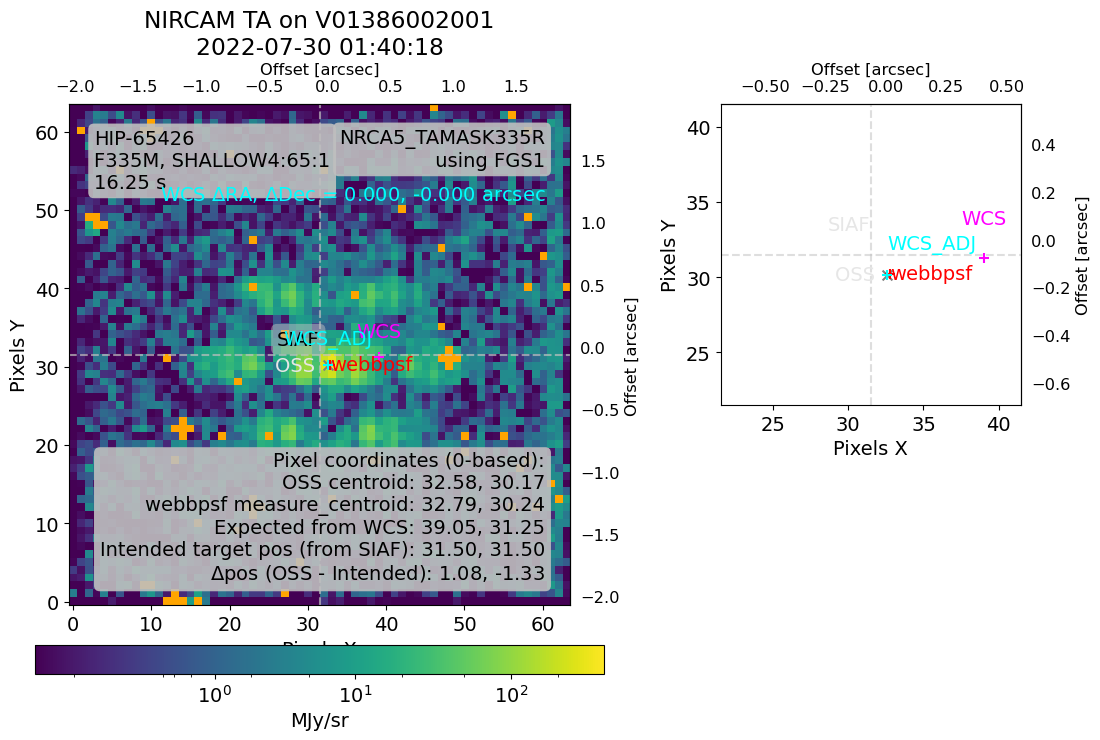

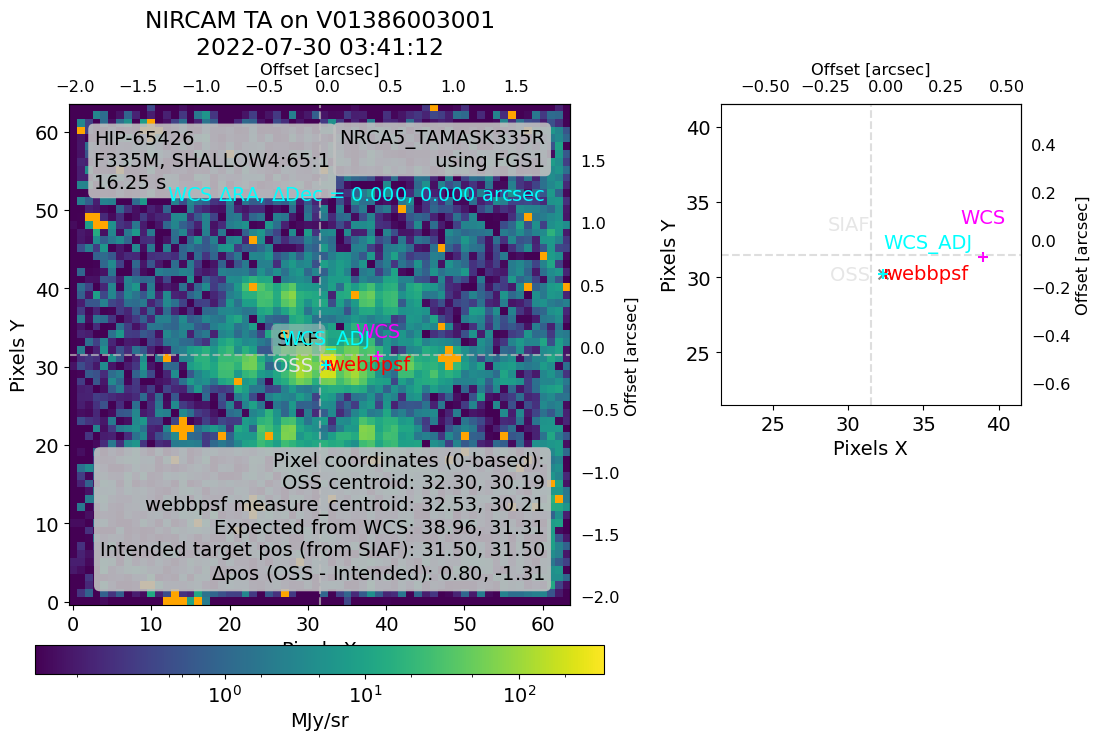

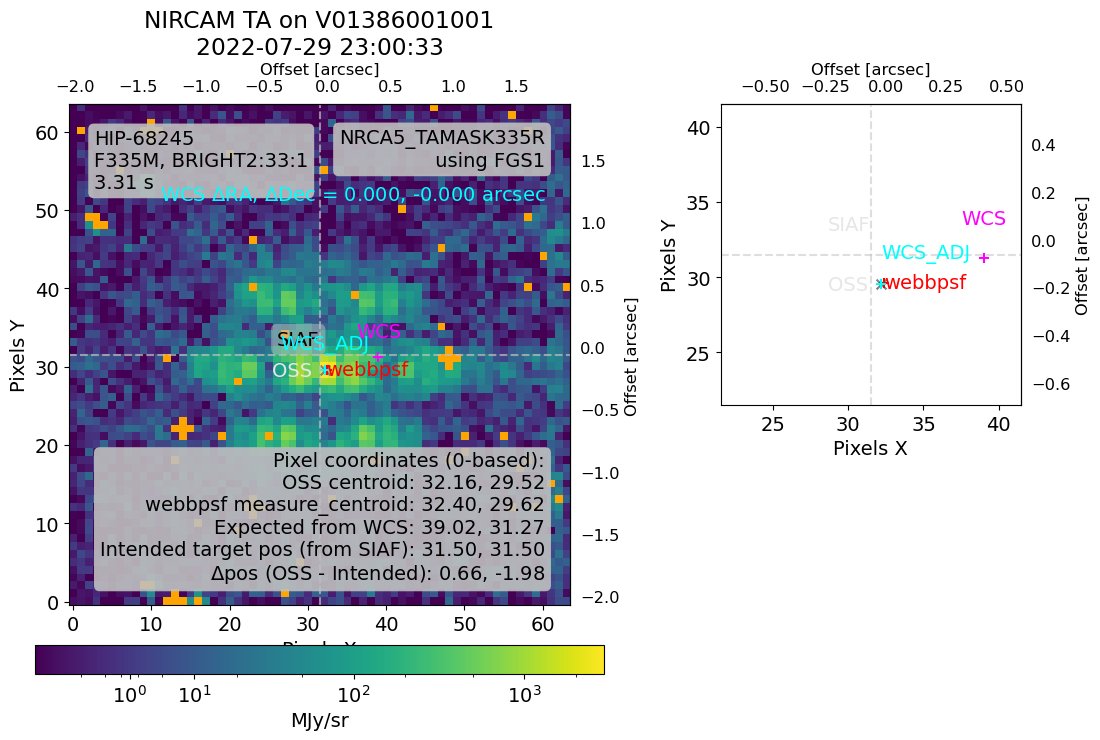

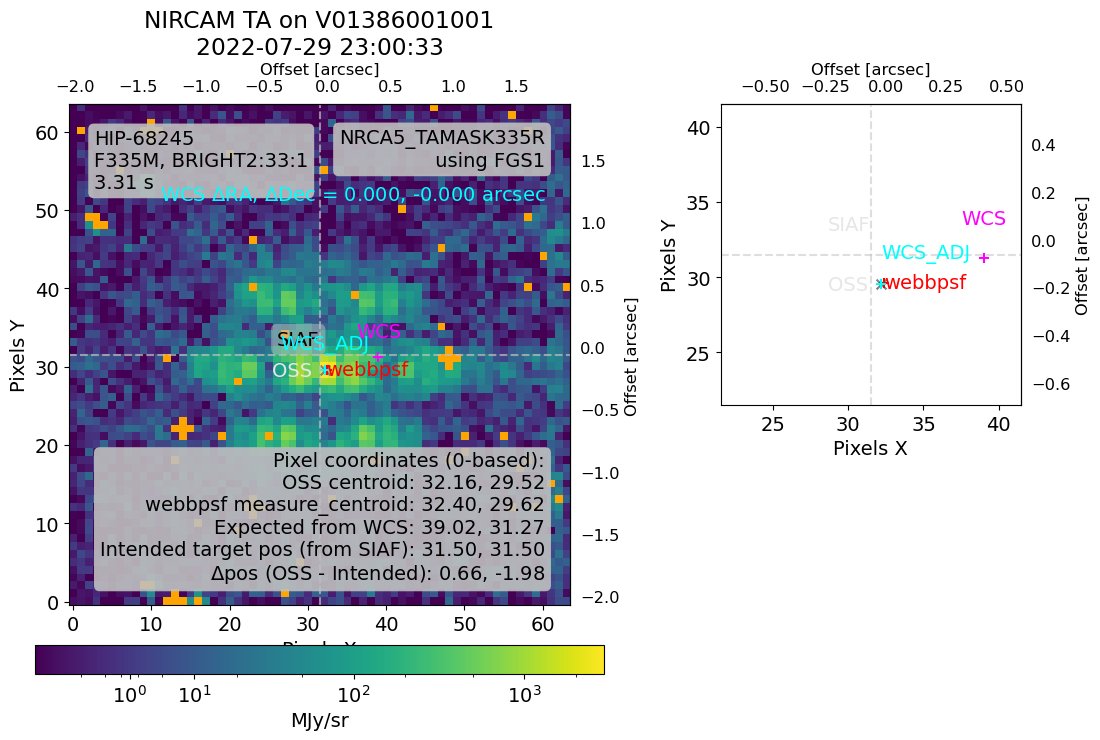

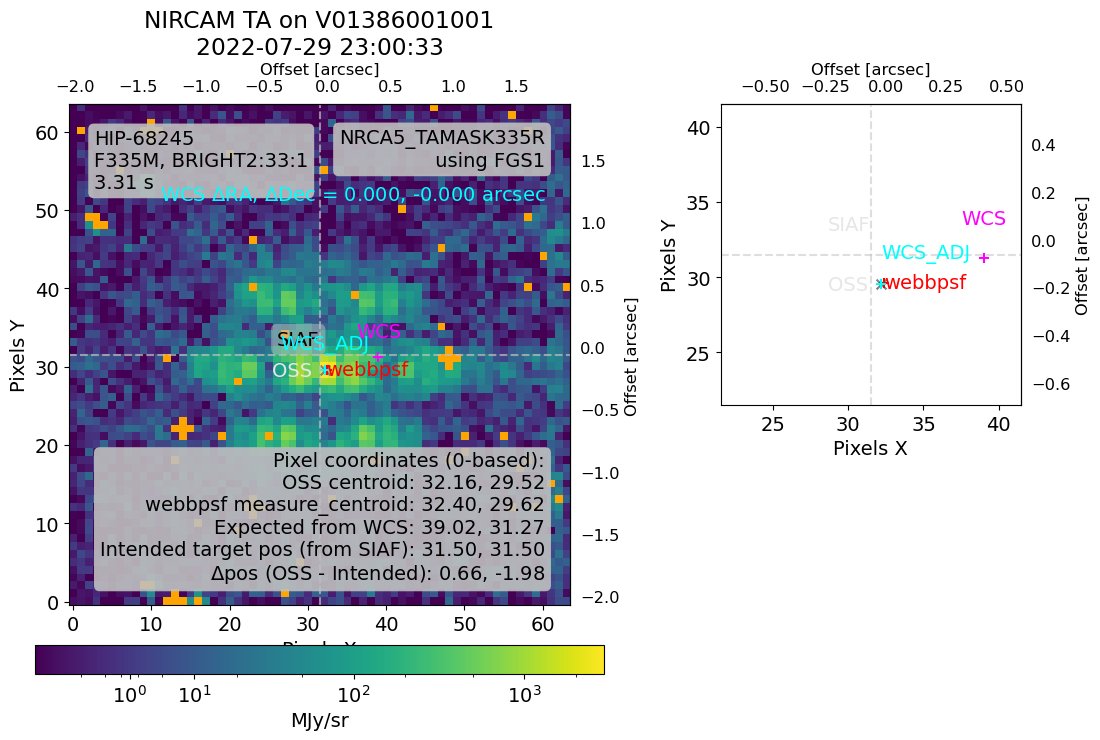

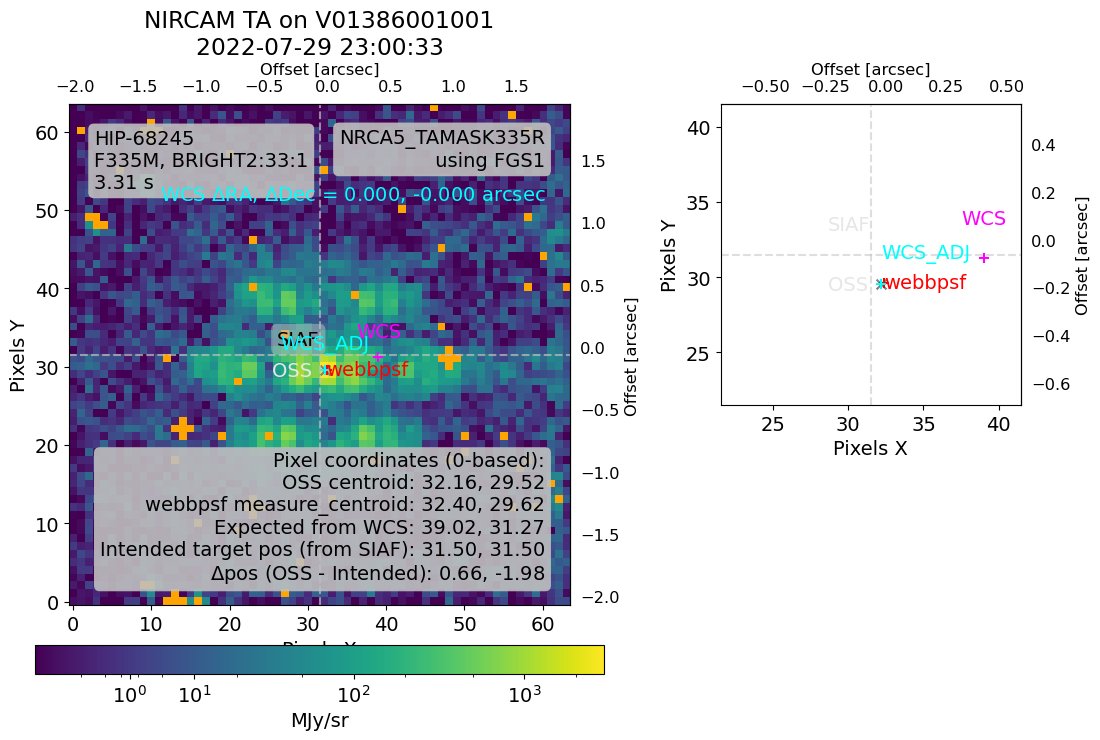

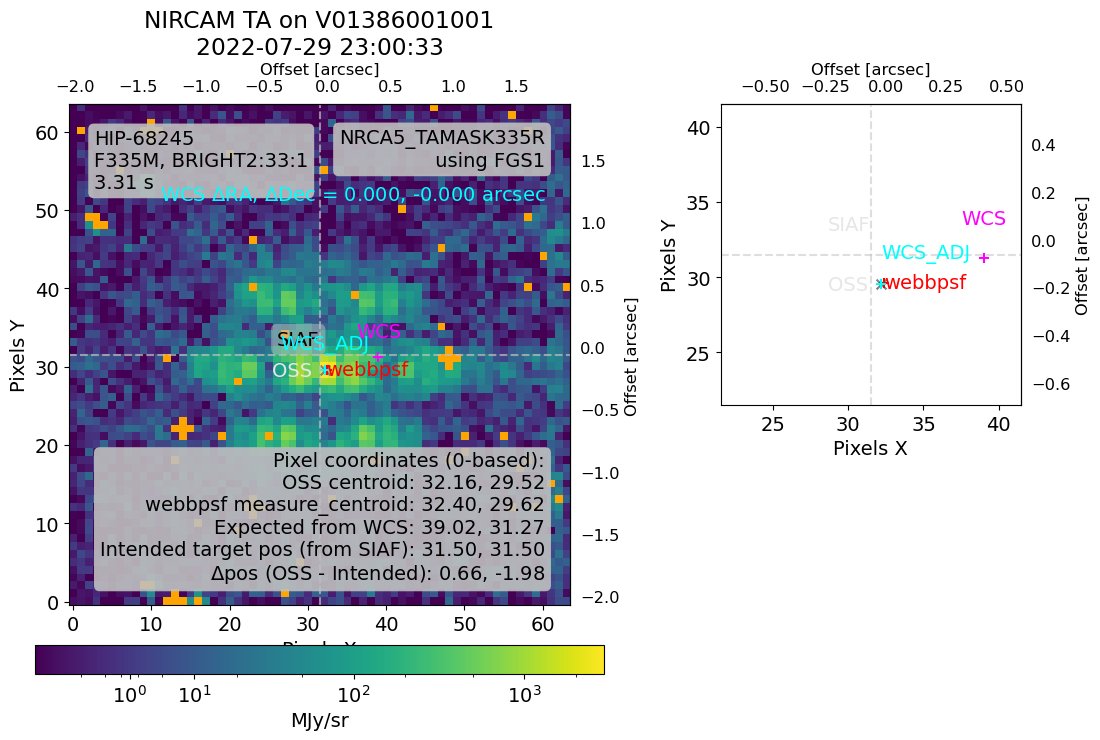

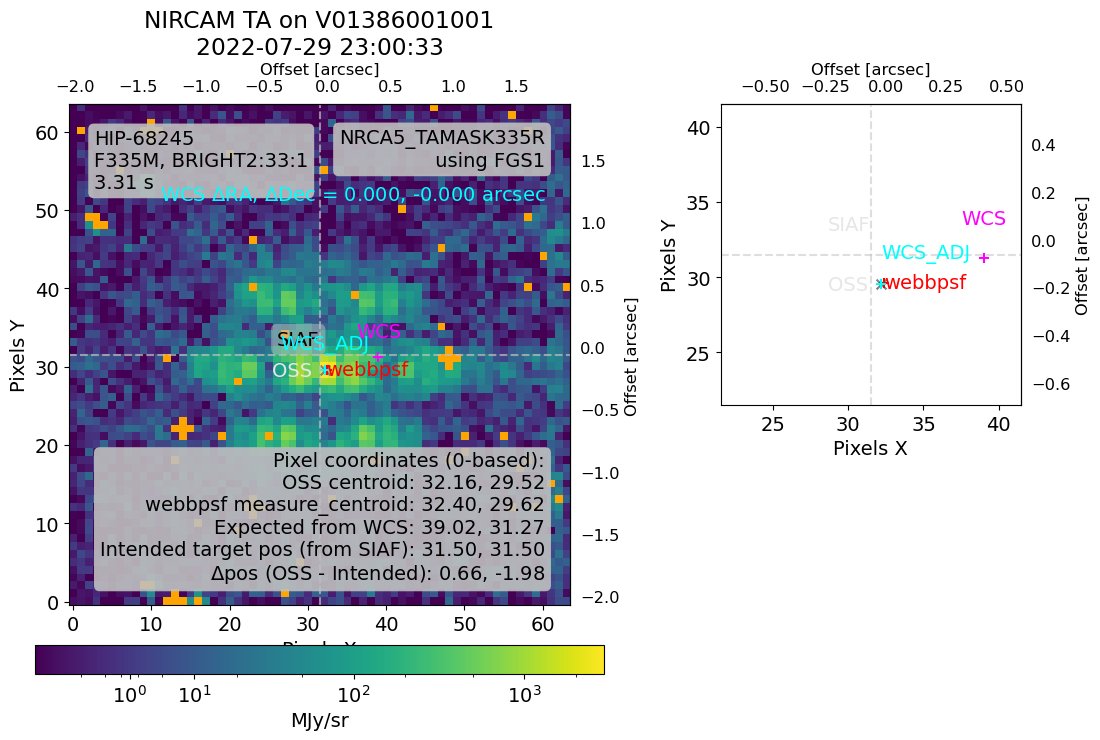

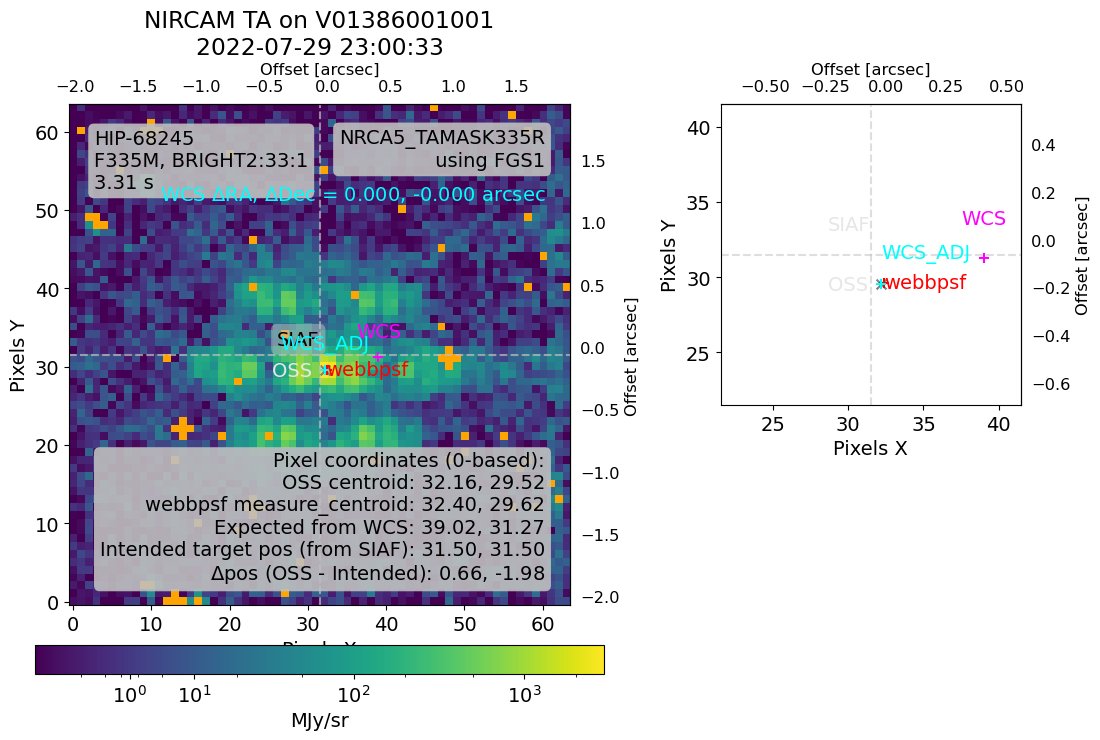

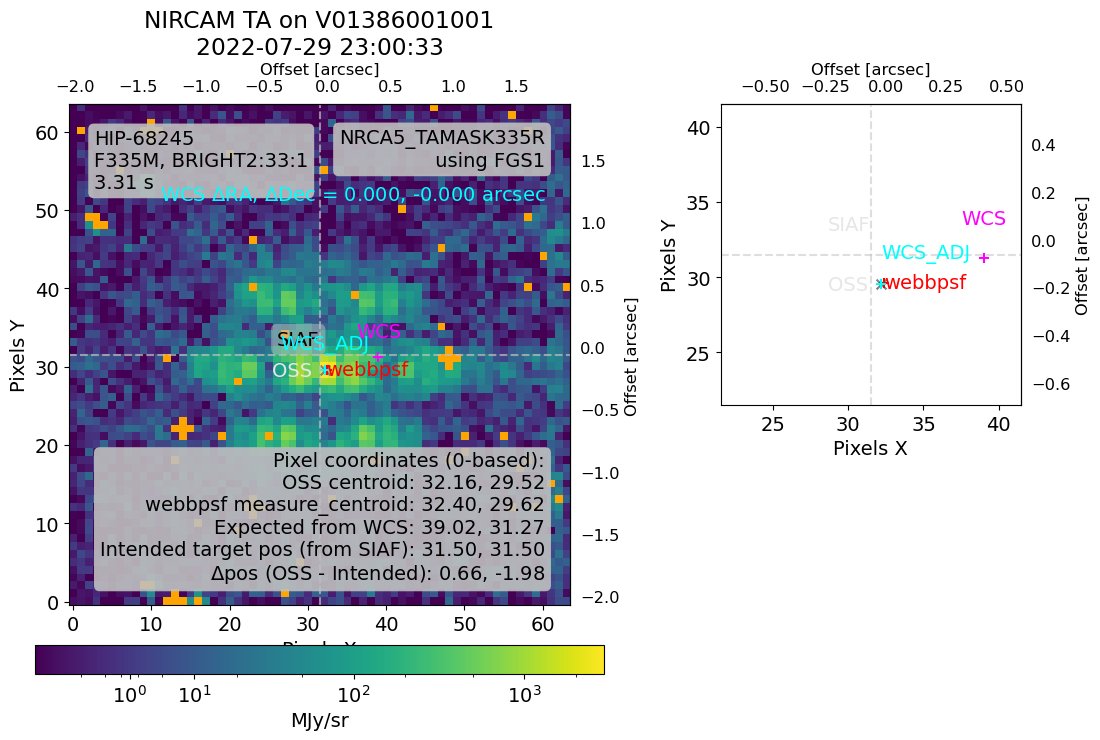

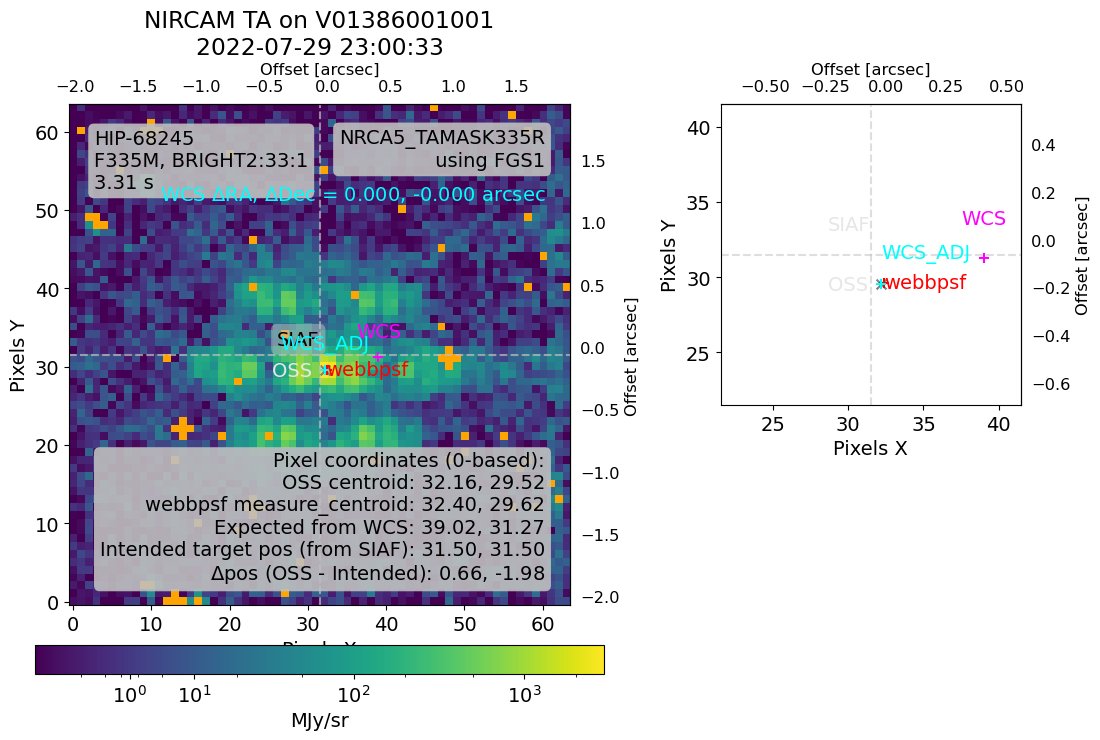

In [47]:
imageTools.recenter_frames_ta(verbose=False, plot=True)

---

### Pad Empty Space Around Frames

To give space to rotate and align during pyklip. This puts a region of NAN pixels around the outside. 

In [40]:
# Pad all frames.
imageTools.pad_frames(npix=80,
                      cval=np.nan,
                      types=['SCI', 'SCI_BG', 'REF', 'REF_BG'],
                      subdir='padded')

[spaceKLIP.imagetools:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386002001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (320, 320), new shape = (480, 480), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386003001_0310a_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (320, 320), new shape = (480, 480), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386001001_0310e_00001_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (320, 320), new shape = (480, 480), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw01386001001_0310e_00002_nrcalong_calints.fits
[spaceKLIP.imagetools:INFO]   --> Frame padding: old shape = (320, 320), new shape = (480, 480), fill value = nan
[spaceKLIP.imagetools:INFO]   --> Frame padding: jw013

---

### Display the Cleaned Datasets 

After applying all the previous steps, review the cleaned data. If you notice artifacts near bad pixels, it is likely that some were not identified and have persisted. To address this, you may need to revisit the bad pixel identification process, adjust the parameters, or add a custom bad pixel map.

**Note**: After recentering and aligning, you may notice image wrapping effects, where parts of the image wrap around from one edge to the opposite edge. This can occur due to the way shifts and transformations are applied. This issue is currently under development to improve the handling of such effects.




In [41]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    restrict_to={'FILTER': filt,  # Sort by filter.
                 'TYPE': ['SCI', 'REF']  # Sort by file type SCI/REF.
    },
    interactive=True,  # Set to False for static plots.
    zoom_center=3,  # Optional zoom factor; set to None to disable.
    bbox_color=None,  # Remove background text boxes.
    save_filename='plots_f444w_stage2_cleaned.pdf'  # Save plots to PDF.
)

IntSlider(value=0, description='Image  Index:', max=10)

Output()

---

## Stage 3 Reductions: KLIP

### PSF Subtraction: Option Using pyKLIP

Now that we have cleaned up our data to account for alignment and bad pixels, we are ready to perform PSF subtraction. SpaceKLIP supports several algorithms for this step, including the recommended [`pyKLIP`](https://pyklip.readthedocs.io/en/latest/index.html) and the JWST [`Coron3Pipeline`](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pipeline.Coron3Pipeline.html). In this case, we will use pyKLIP for subtraction.

You can customize the PSF subtraction process by adjusting the following settings:

> * `mode`: Choose from different image processing techniques, such as ADI, RDI, or a combination of both.
> * `annuli`: This parameter determines the number of concentric ring-shaped regions used for PSF subtraction. By specifying different numbers of annuli, you control the radial regions where the subtraction is applied, helping to remove the PSF at various distances from the center of the star. Default is [1].
> * `subsections`: This parameter defines the number of smaller regions or segments within each annulus where the PSF subtraction is applied. By breaking down the annuli into subsections, the algorithm can fine-tune the subtraction process. The default value is [1].
> * Number of KL Modes (`numbasis`): This parameter specifies how many Principal Component Analysis (PCA) modes are used to build the PSF model for subtraction. PCA modes capture different patterns and features in the data, allowing the model to represent and subtract the PSF more accurately. The default values are [1, 2, 5, 10, 20, 50, 100], which allows us to test different PSF models.
> * `algo`: Select the processing algorithm (here, klip).
> * `save_rolls`: A roll refers to a set of images taken during a specific pointing direction or orientation of the telescope. Enabling this parameter will save the PSF-subtracted versions of each individual science roll separately, in addition to the roll-combined final product.







These options help tailor the analysis to better suit your specific data and objectives.

In [42]:
# Run pyKLIP pipeline. Additional parameters for klip_dataset function can
# be passed using kwargs parameter.
spaceKLIP.pyklippipeline.run_obs(database=database,
                       kwargs={'mode': ['ADI', 'RDI', 'ADI+RDI'],
                               'annuli': [1],
                               'subsections': [1],
                               'numbasis': [1, 2, 5, 10, 20, 50],
                               'algo': 'klip',
                               'save_rolls': True},
                       subdir='klipsub')


[spaceKLIP.pyklippipeline:INFO] --> Concatenation JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /System/Volumes/Data/user/kglidic/spaceKLIP/docs/source/tutorials/data_nircam_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 4, 1, 480, 480)
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = RDI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /System/Volumes/Data/user/kglidic/spaceKLIP/docs/source/tutorials/data_nircam_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 4, 1, 480, 480)
[spaceKLIP.pyklippipeline:INFO]   --> pyKLIP: mode = ADI+RDI, annuli = 1, subsections = 1
Begin align and scale images for each wavelength
Wavelength 4.439e-06 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 1


  0%|          | 0/1 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory /System/Volumes/Data/user/kglidic/spaceKLIP/docs/source/tutorials/data_nircam_hd65426/klipsub
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 4, 1, 480, 480)
[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- -------------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


The stage 3 information in the database is added to another table. The stage 2 information remains in the database, which is needed to maintain the information on rolls and references used in the reduction for forward modeling. 
In fact the stage 3 outputs include a JSON file that includes the table of the stage 2 data, so if you read in the stage 3 outputs it also learns about the stage 2 inputs.

In [33]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 11 files;	2 SCI, 9 REF
	STAGE3: 3 files;	3 PYKLIP


---

### Optional: Re-read Stage 3 Outputs into Database 
This shows how you can start re-analyses at this point, once you have run the previous steps.

Note, to read in stage 3 data you must set the `readlevel` parameter to 3. This invokes code for reading the stage-3 formatted data products, and also implicitly reads in the metadata about the stage 2 files used as input to stage 3. 

In [43]:
database = spaceKLIP.database.create_database(
                                    input_dir=os.path.join(data_root, 'klipsub'),
                                    file_type='*KLmodes-all.fits',
                                    output_dir=data_root,
                                    readlevel=3,
                                    pid=1386)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_NIRCAM_NRCALONG_F444W_MASKRND_MASK335R_SUB320A335R
 TYPE   EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ --------- -------- -------- ... -------- -------------- ------ --------
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP NRC_CORON   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


In [35]:
database.summarize()

NIRCAM_F444W_MASK335R
	STAGE2: 11 files;	2 SCI, 9 REF
	STAGE3: 3 files;	3 PYKLIP


---

In [44]:
spaceKLIP.plotting.display_coron_dataset(
    database,
    stage3=True,
    restrict_to=filt,  # Sort by filter.
    interactive=True,  # Static or interactive plots?
    zoom_center=5,  # Optional zoom factor; set to None to disable.
    bbox_color=None,  # Remove background text boxes.
    save_filename='plots_f444w_pyklip.pdf'  # Save plots to PDF.
)

IntSlider(value=0, description='Image  Index:', max=2)

Output()

Hurray! We’ve reached the end of the reduction process for NIRCam coronagraphic data. Now, we can move on to Part 2 of this tutorial to analyze the results. At this stage, the planet should appear to the lower left of the KLIP center (indicated by the orange point), along with other background sources. To get a closer look at the planet, consider increasing the `zoom_center` factor in the plot function above.